# Practical Application III: Comparing Classifiers

**Overview**: In this project, my goal is to compare the performance of the classifiers such as K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  I am utilizing the dataset related to bank marketing over the telephone.  



**Data Overview**: The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. 
Dataset contains 20 features and 1 target variable.




Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns. This article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



## Section 1: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
import time
from sklearn.svm import SVC

from sklearn import set_config
set_config(display="diagram") #setting this will display your pipelines as seen above
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

In [2]:
bank_input_df = pd.read_csv('/Users/apoorvaacharya/Documents/Projects/AI Journey/Berkeley/Practical 3/module_17_starter/data/bank-additional-full.csv', sep = ',')
    #'/Users/apoorvaacharya/Documents/Projects/AI Journey/Berkeley/Practical 3/Bank_Project/bank+marketing/bank/bank-full.csv', sep=";")
print('Total number of records in data', len(bank_input_df))

Total number of records in data 41188


In [3]:
bank_input_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
features = bank_input_df.columns.tolist()
print(f'Number of Features: {len(features)}')
#print(features)
bank_input_df.dtypes

Number of Features: 21


age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

## Section 2: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



#### Understanding Categorical Variables ###

In [5]:
cat_df = bank_input_df.select_dtypes(include=object)
cat_features = cat_df.columns.tolist()
print(f'Number of categorical features: {len(cat_features)}')
cat_df


Number of categorical features: 11


,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,nonexistent,no
1,services,married,high.school,unknown,no,no,telephone,may,mon,nonexistent,no
2,services,married,high.school,no,yes,no,telephone,may,mon,nonexistent,no
3,admin.,married,basic.6y,no,no,no,telephone,may,mon,nonexistent,no
4,services,married,high.school,no,no,yes,telephone,may,mon,nonexistent,no
...,...,...,...,...,...,...,...,...,...,...,...
41183,retired,married,professional.course,no,yes,no,cellular,nov,fri,nonexistent,yes
41184,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,nonexistent,no
41185,retired,married,university.degree,no,yes,no,cellular,nov,fri,nonexistent,no
41186,technician,married,professional.course,no,no,no,cellular,nov,fri,nonexistent,yes



Total types of Campaigns: 42; 
 Campaign types [ 1  2  3  4  5  6  7  8  9 10 11 12 13 19 18 23 14 22 25 16 17 15 20 56
 39 35 42 28 26 27 32 21 24 29 31 30 41 37 40 33 34 43]

 Total types of Jobs 12; 
 Job types ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']

 Total types of Education types 8; 
 Education types ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']

Target population description : people who have subscribed to term deposit (yes) verus those who did not (no)
y
no     0.887346
yes    0.112654
Name: proportion, dtype: float64


Text(0.5, 1.0, 'Target population description : people who have subscribed to term deposit (yes) verus those who did not (no)')

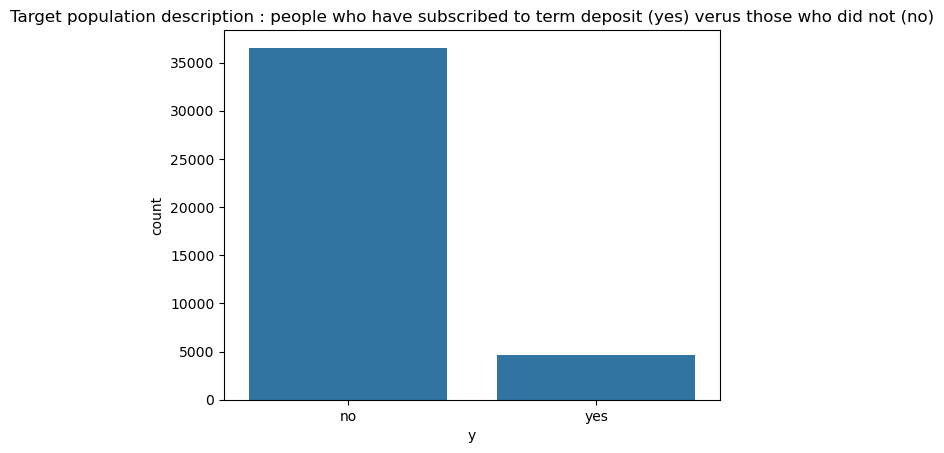

In [6]:
campaign_types = bank_input_df.campaign.unique()
job_types = bank_input_df.job.unique()
education_types = bank_input_df.education.unique()
print(f'\nTotal types of Campaigns: {len(campaign_types)}; \n Campaign types {campaign_types}')
print(f'\n Total types of Jobs {len(job_types)}; \n Job types {job_types}')
print(f'\n Total types of Education types {len(education_types)}; \n Education types {education_types}')

print('\nTarget population description : people who have subscribed to term deposit (yes) verus those who did not (no)')
print(bank_input_df['y'].value_counts(normalize=True))
sns.countplot(data=bank_input_df, x='y')
plt.title('Target population description : people who have subscribed to term deposit (yes) verus those who did not (no)')

### Understanding Campaign Data:  92% of records are running on campaigns 1, 2, 3, 4 & 5.

Conclusion: 92.0% records are in campaigns : 1,2,3,4 & 5


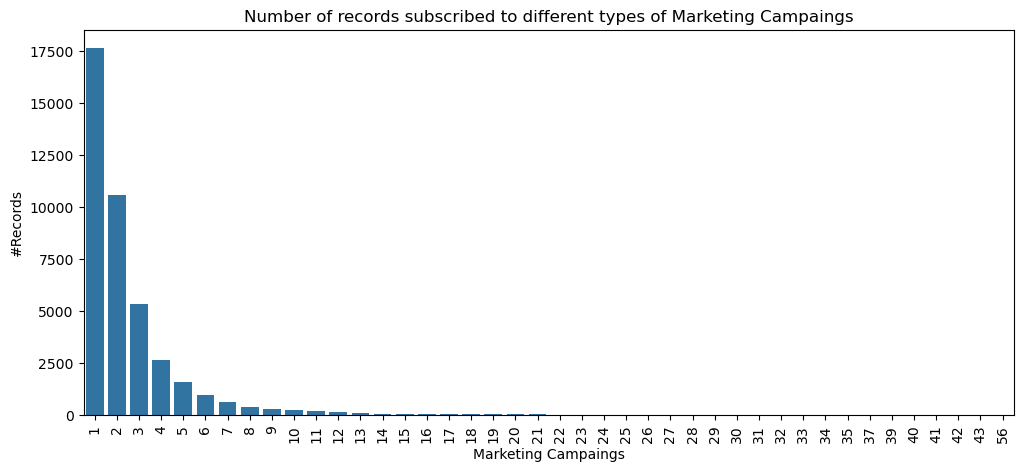

In [7]:

plt.figure(figsize=[12,5])
sns.countplot(data=bank_input_df, x='campaign')
plt.title("Number of records subscribed to different types of Marketing Campaings")
plt.xlabel("Marketing Campaings")
plt.ylabel("#Records")
plt.xticks(rotation=90)

pd.crosstab(bank_input_df.y, bank_input_df.campaign)
percentage= round(bank_input_df['campaign'].isin([1,2,3,4,5]).sum()/len(bank_input_df['campaign']), 2)*100
print(f'Conclusion: {percentage}% records are in campaigns : 1,2,3,4 & 5')

### Understanding Education Data: People wih any education background are majority. Further, people with university degree has most records of subscribign to term deposit.

<Axes: xlabel='education'>

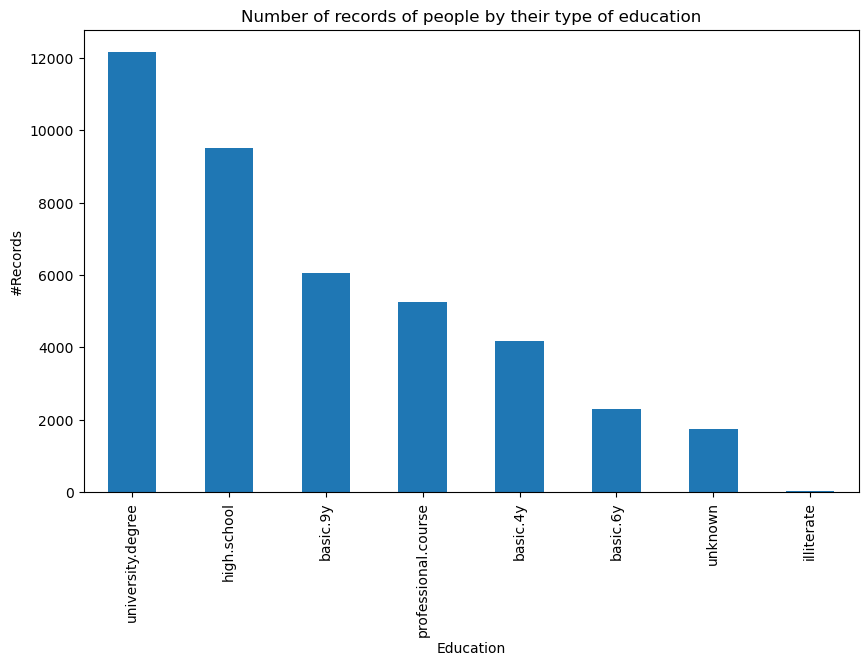

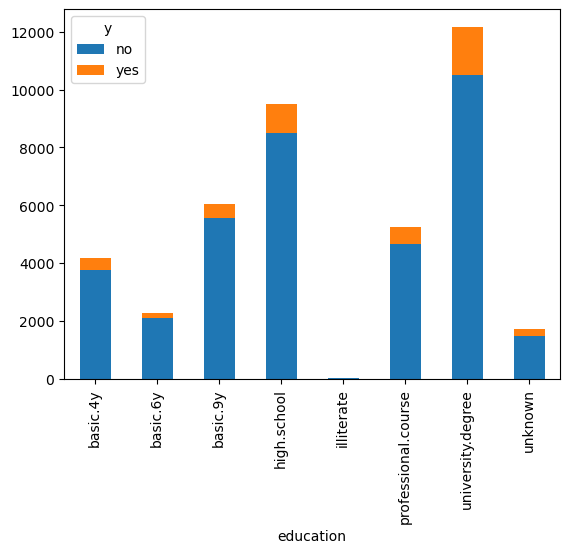

In [8]:
# Understanding Education Data

plt.figure(figsize=[12,5])
bank_input_df['education'].value_counts().plot(kind='bar', figsize=(10,6))
plt.title("Number of records of people by their type of education")
plt.xlabel("Education")
plt.ylabel("#Records")
plt.xticks(rotation=90)

pd.crosstab(bank_input_df.y, bank_input_df.education)
bank_input_df.groupby(['education', 'y']).size().unstack().plot(kind='bar', stacked=True)


### Understanding Job Data: Majority have admin job role and have accepted term deposit subscription. Next job type who accepted term deposit subscription are technicians.

<Axes: xlabel='job'>

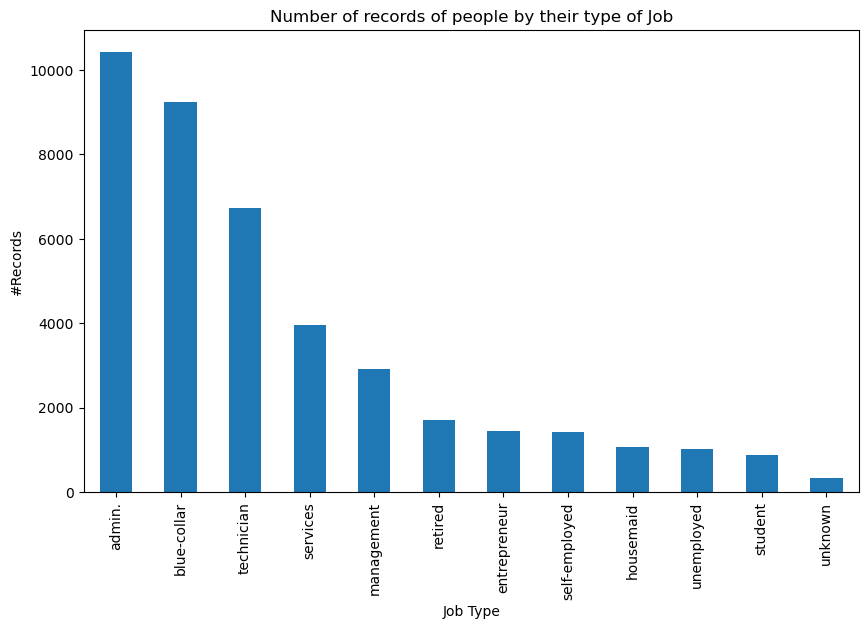

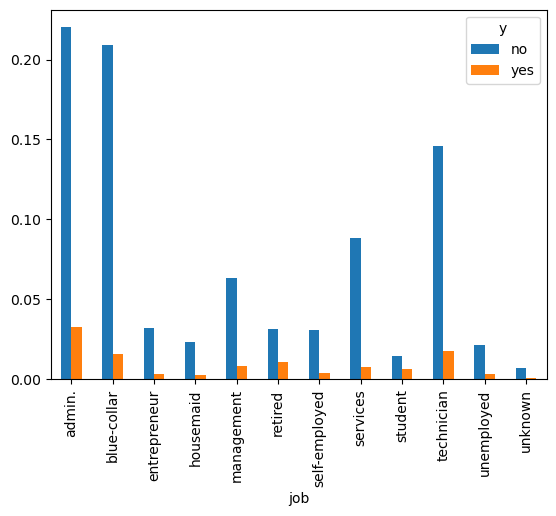

In [9]:
bank_input_df['job'].value_counts().plot(kind='bar', figsize=(10,6))
plt.title("Number of records of people by their type of Job")
plt.xlabel("Job Type")
plt.ylabel("#Records")
plt.xticks(rotation=90)


pd.crosstab(bank_input_df.job, bank_input_df.y, normalize = True).plot(kind = 'bar')


### There are high % of people who have admin job and have university degree

<Axes: xlabel='education', ylabel='job'>

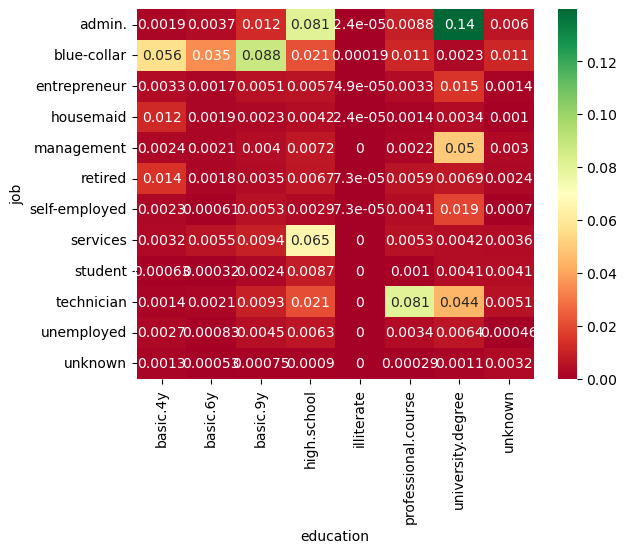

In [10]:
sns.heatmap(pd.crosstab(bank_input_df.job, bank_input_df.education, normalize = True),cmap = "RdYlGn", annot=True)


### Most people who have been reached through cellular network have accepted subscription as per data

<Axes: xlabel='contact'>

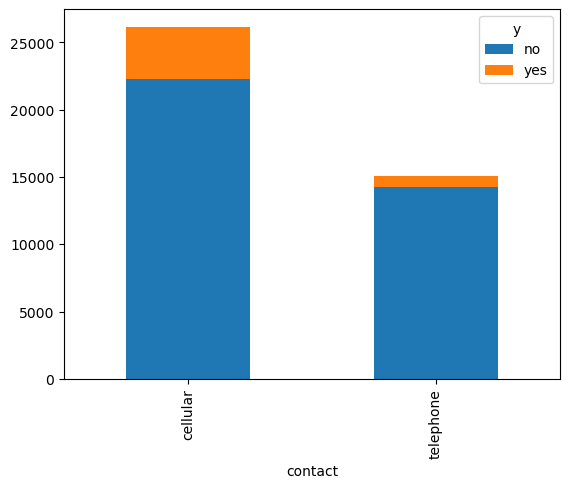

In [11]:
#pd.crosstab(bank_input_df.y, bank_input_df.contact)
bank_input_df.groupby(['contact', 'y']).size().unstack().plot(kind='bar', stacked=True)


### Married people have subscribed to term deposit the most

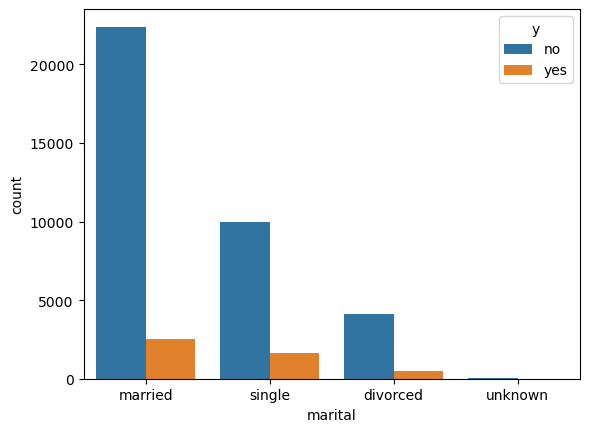

In [12]:
sns.countplot(data=bank_input_df, x='marital', hue='y');

### Most records of people having housing loan has high subscription to term deposit.
### While, people who have NOT taken personal loan or have default credit have highest subscription to term deposit.

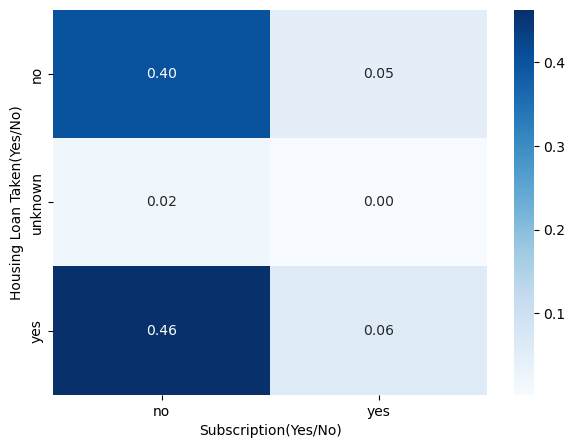

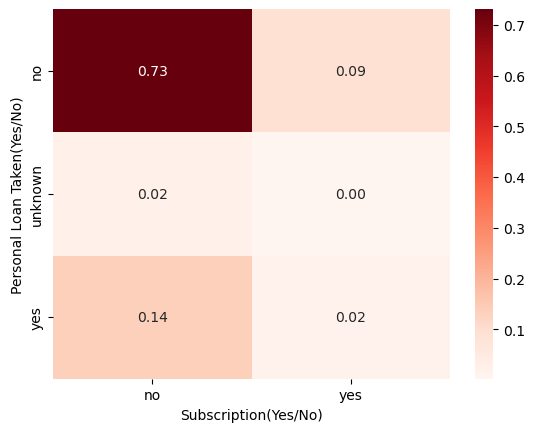

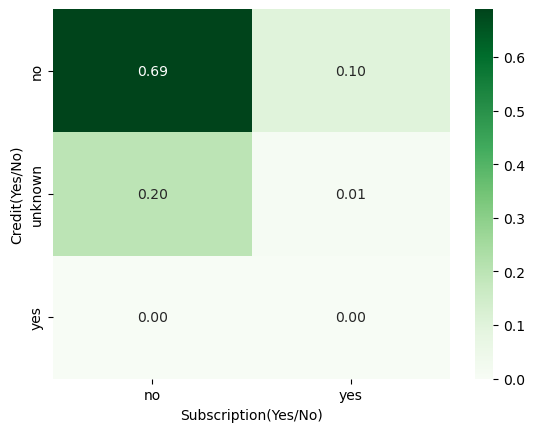

In [13]:
plt.figure(figsize=[7,5])
sns.heatmap(pd.crosstab(bank_input_df.housing, bank_input_df.y, normalize = True),cmap='Blues', fmt='.2f', annot=True)
plt.xlabel('Subscription(Yes/No)')
plt.ylabel('Housing Loan Taken(Yes/No)')
plt.show()

sns.heatmap(pd.crosstab(bank_input_df.loan, bank_input_df.y, normalize = True),cmap = "Reds",fmt='.2f', annot=True)
plt.xlabel('Subscription(Yes/No)')
plt.ylabel('Personal Loan Taken(Yes/No)')
plt.show()

sns.heatmap(pd.crosstab(bank_input_df.default, bank_input_df.y, normalize = True),cmap = "Greens",fmt='.2f', annot=True)
plt.xlabel('Subscription(Yes/No)')
plt.ylabel('Credit(Yes/No)')
plt.show()


### Understanding Numerical Variables ###

In [14]:
num_df = bank_input_df.select_dtypes(exclude=object)
num_features = num_df.columns.tolist()
print(f'Number of numeric features: {len(num_features)}')
num_df


Number of numeric features: 10


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0
...,...,...,...,...,...,...,...,...,...,...
41183,73,334,1,999,0,-1.1,94.767,-50.8,1.028,4963.6
41184,46,383,1,999,0,-1.1,94.767,-50.8,1.028,4963.6
41185,56,189,2,999,0,-1.1,94.767,-50.8,1.028,4963.6
41186,44,442,1,999,0,-1.1,94.767,-50.8,1.028,4963.6


### Only age has normally distributed data

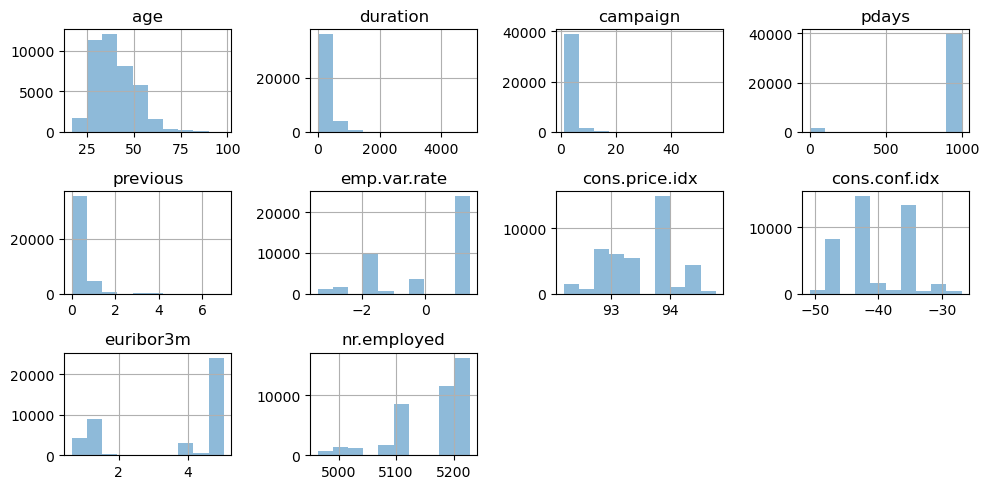

In [15]:
allhistograms = bank_input_df.hist(figsize= [10,5], layout=(3,4), alpha=0.5)
plt.tight_layout()
allhistograms
plt.show()

### Mean age of people subscribed or have not subscribed is same (~40)

In [16]:
#bank_input_df.query("Revenue >= 50")['Units Sold'].sum()
bank_input_df.groupby(['y'])['age'].mean().reset_index()


,y,age
0,no,39.911185
1,yes,40.913147


<Axes: title={'center': 'Subscription Vs Age'}, xlabel='y', ylabel='age'>

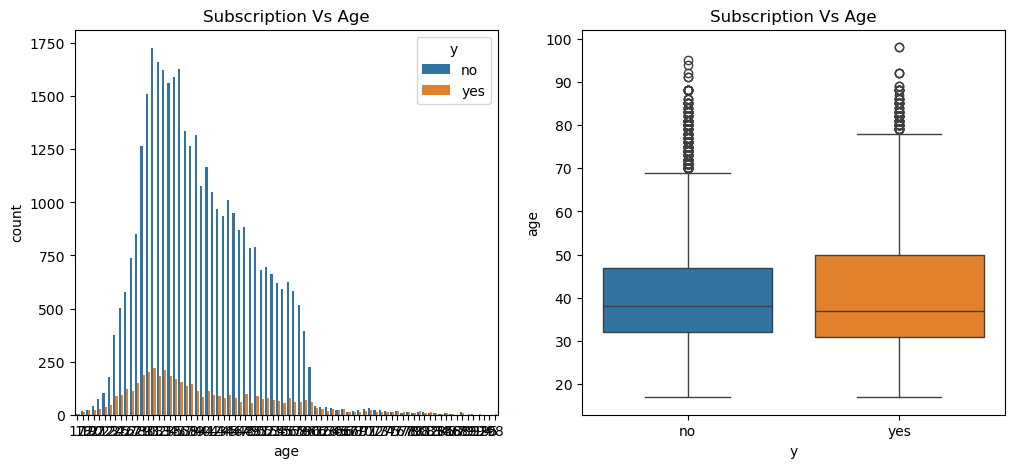

In [17]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title('Subscription Vs Age')
sns.countplot(x='age',hue='y',data=bank_input_df )

plt.subplot(122)
plt.title('Subscription Vs Age')
sns.boxplot(x=bank_input_df['y'],y=bank_input_df['age'],hue='y',data=bank_input_df)

## Section 3: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

#### Problem Statement: Predict whether customer is going to subscribe to term deposition or not, given customer's bank marketing campaign data and personal information

In [18]:
bank_input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

## Section 4: Feature Engineering

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

### No null values to be removed

In [19]:
bank_input_df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic prediction

In [20]:
# bank_input_df = bank_input_df.drop(['duration'], axis = 1)

In [21]:
bank_input_df['y'].value_counts()

y
no     36548
yes     4640
Name: count, dtype: int64

In [22]:
X = bank_input_df.drop(['y'], axis=1)
y = bank_input_df['y']


In [23]:
Xcat_features = X.select_dtypes(include=object).columns.tolist()
Xnum_features = X.select_dtypes(exclude=object).columns.tolist()
print(Xcat_features)

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']


#### Encoding each categorical feature value to boolean and scaling numerical values

In [24]:

transformer = make_column_transformer((OneHotEncoder(drop = 'if_binary'), np.array(Xcat_features)),(StandardScaler(), np.array(Xnum_features)))
transformed = transformer.fit_transform(X)

encoded_feature_names = transformer.get_feature_names_out()
encoded_feature_names = [x.replace("onehotencoder__", "") for x in encoded_feature_names] 
encoded_feature_names = [x.replace("standardscaler__", "") for x in encoded_feature_names] 


X_transformed = pd.DataFrame(transformed, columns = encoded_feature_names)
X_transformed

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.533034,0.010471,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.712460,0.331680
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.628993,-0.421501,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.712460,0.331680
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.290186,-0.124520,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.712460,0.331680
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.002309,-0.413787,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.712460,0.331680
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.533034,0.187888,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.712460,0.331680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,3.164336,0.292025,-0.565922,0.195414,-0.349494,-0.752343,2.058168,-2.224953,-1.495186,-2.815697
41184,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.573445,0.481012,-0.565922,0.195414,-0.349494,-0.752343,2.058168,-2.224953,-1.495186,-2.815697
41185,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.533034,-0.267225,-0.204909,0.195414,-0.349494,-0.752343,2.058168,-2.224953,-1.495186,-2.815697
41186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.381527,0.708569,-0.565922,0.195414,-0.349494,-0.752343,2.058168,-2.224953,-1.495186,-2.815697


In [25]:
transformed

array([[ 0.        ,  0.        ,  0.        , ...,  0.88644656,
         0.71245988,  0.33167991],
       [ 0.        ,  0.        ,  0.        , ...,  0.88644656,
         0.71245988,  0.33167991],
       [ 0.        ,  0.        ,  0.        , ...,  0.88644656,
         0.71245988,  0.33167991],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -2.22495344,
        -1.49518647, -2.8156966 ],
       [ 0.        ,  0.        ,  0.        , ..., -2.22495344,
        -1.49518647, -2.8156966 ],
       [ 0.        ,  0.        ,  0.        , ..., -2.22495344,
        -1.49518647, -2.8156966 ]])

In [26]:
## Converting the target variables into 0s and 1s
y.replace('no', 0,inplace=True)
y.replace('yes', 1,inplace=True)
y

0        0
1        0
2        0
3        0
4        0
        ..
41183    1
41184    0
41185    0
41186    1
41187    0
Name: y, Length: 41188, dtype: int64

### Employement variation rate is highliy nr.employed, euribor3m. None of the features are highly correlated to target- y

<Axes: >

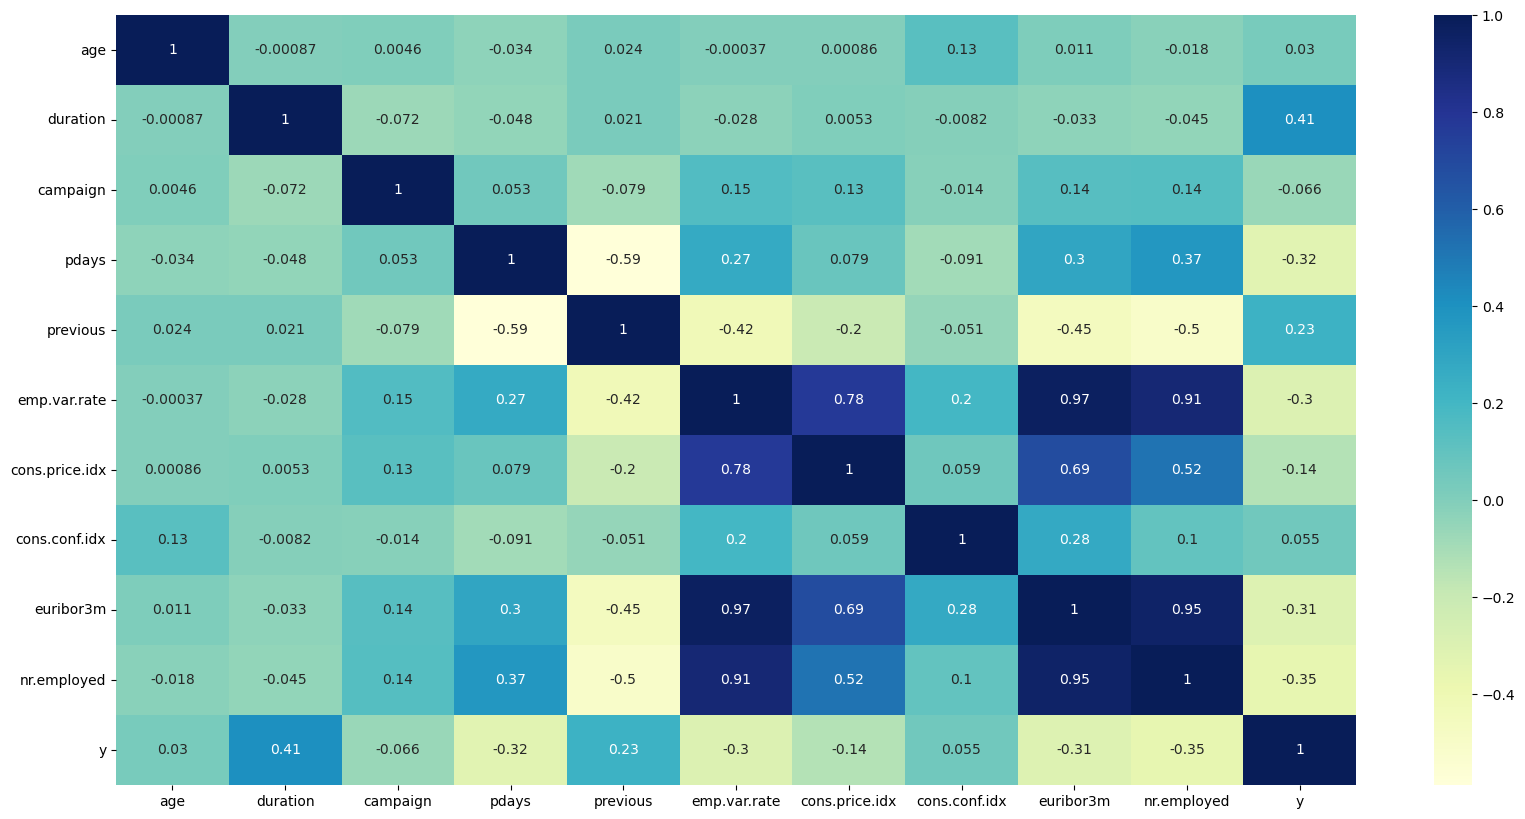

In [27]:
corr_df =  pd.concat([X.select_dtypes(exclude=object),y], axis =1)

fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corr_df.corr(), annot=True, cmap='YlGnBu')

## Section 5: Train/Test Split

With your data prepared, split it into a train and test set.

In [28]:
### Splitting test data as 25%
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=.25, random_state=42)
print("Size of training data:",X_train.shape, y_train.shape)
print("Size of test data:",X_test.shape, y_test.shape)


Size of training data: (30891, 62) (30891,)
Size of test data: (10297, 62) (10297,)


## Section 6: Modeling

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [29]:
baseline_log_model = LogisticRegression(random_state=42).fit(X_train, y_train)
train_preds = baseline_log_model.predict(X_train)
test_preds = baseline_log_model.predict(X_test)
baseline_train_acc = round(baseline_log_model.score(X_train, y_train),3)
baseline_test_acc = round(baseline_log_model.score(X_test, y_test),3)
#print("Baseline Train Accuracy:", baseline_train_acc)
print("Baseline Test Accuracy:", baseline_test_acc)


Baseline Test Accuracy: 0.913


In [30]:
### Cross Validation 

from sklearn.model_selection import cross_val_score

scores = cross_val_score(baseline_log_model, X_train, y_train, cv=10)
scores = pd.Series([round(i, 3) for i in scores])
print('Cross-Validation Accuracy Scores', scores)
scores.min(), round(scores.mean(), 3), scores.max()

Cross-Validation Accuracy Scores 0    0.909
1    0.912
2    0.905
3    0.916
4    0.913
5    0.904
6    0.915
7    0.916
8    0.913
9    0.910
dtype: float64


(0.904, 0.911, 0.916)

So the range of our accuracy of our baseline model is between 0.90 to 0.915 but generally 0.91 on average.

## Section 7: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

#### Training KNN Classifier with default variables

In [31]:
knn_pipe = Pipeline([('knn', KNeighborsClassifier())])
knn_pipe.fit(X_train, y_train)
preds = knn_pipe.predict(X_test)
train_mse = round(mean_squared_error(y_train, knn_pipe.predict(X_train)),3)
test_mse = round(mean_squared_error(y_test, preds),3)
acc = round(accuracy_score(y_test, preds),2)


print("Train MSE:", train_mse)
print("Test MSE:", test_mse)
print("Accuracy Score", acc)

print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))

Train MSE: 0.073
Test MSE: 0.097
Accuracy Score 0.9
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      9144
           1       0.59      0.44      0.51      1153

    accuracy                           0.90     10297
   macro avg       0.76      0.70      0.73     10297
weighted avg       0.89      0.90      0.90     10297

[[8792  352]
 [ 644  509]]


In [32]:
knn_pipe.get_params()

{'memory': None,
 'steps': [('knn', KNeighborsClassifier())],
 'verbose': False,
 'knn': KNeighborsClassifier(),
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 5,
 'knn__p': 2,
 'knn__weights': 'uniform'}

#### GridSearch Cross Validation of KNN Classifier to get best parameter

In [33]:
start_time = time.time()

knn_grid = GridSearchCV(knn_pipe, param_grid={'knn__n_neighbors': range(1, 33, 2)}, scoring = 'roc_auc')
knn_grid.fit(X_train, y_train)
best_k = knn_grid.best_params_['knn__n_neighbors']
print("Best N Neighbors:", best_k)
knn_grid_preds = knn_grid.predict(X_test)
knn_grid_train_mse = round(mean_squared_error(y_train, knn_grid.predict(X_train)),3)
knn_grid_test_mse = round(mean_squared_error(y_test, knn_grid_preds),3)
knn_grid_best_params = knn_grid.best_params_
knn_grid_best_params['train_acc'] = round(accuracy_score(y_train, knn_grid.predict(X_train)),3)
knn_grid_best_params['test_acc'] = round(accuracy_score(y_test, knn_grid.predict(X_test)),3)
knn_grid_best_params['time'] = (time.time() - start_time)
knn_grid_best_params['accuracy']  = accuracy_score(y_test, knn_grid_preds)
knn_grid_best_params['precision']  = precision_score(y_test, knn_grid_preds)
knn_grid_best_params['recall']  = recall_score(y_test, knn_grid_preds)
knn_grid_best_params['f1_score']  = f1_score(y_test, knn_grid_preds)

grid_acc = round(accuracy_score(y_test, knn_grid_preds),2)
print("Train MSE:", knn_grid_train_mse)
print("Test MSE:", knn_grid_test_mse)
print("Accuracy Score", grid_acc)



Best N Neighbors: 31
Train MSE: 0.089
Test MSE: 0.092
Accuracy Score 0.91


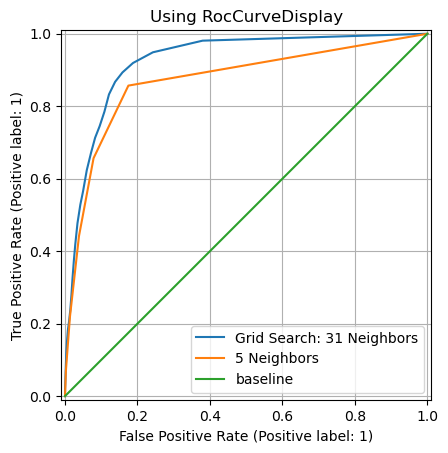

In [34]:
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots()
RocCurveDisplay.from_estimator(knn_grid, X_test, y_test, pos_label = 1, ax = ax, label = 'Grid Search: 31 Neighbors')
RocCurveDisplay.from_estimator(knn_pipe, X_test, y_test, pos_label = 1, ax = ax, label = '5 Neighbors')
#RocCurveDisplay.from_estimator(knn_1, X_test, y_test, ax = ax, label = '1 Neighbor')
plt.grid()
plt.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), label = 'baseline');
plt.title('Using RocCurveDisplay')
plt.legend();




### Training Logistic Regression model on  data.  

In [35]:
from sklearn.feature_selection import SelectFromModel

lr_grid={"C":np.logspace(-3,3,7), "penalty":["l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,param_grid=lr_grid,cv=10)
logreg_cv.fit(X_train, y_train)


GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l2']})

In [36]:
start_time = time.time()
lr_grid_preds = logreg_cv.predict(X_test)
lr_grid_train_mse = round(mean_squared_error(y_train, logreg_cv.predict(X_train)),3)
lr_grid_test_mse = round(mean_squared_error(y_test, lr_grid_preds),3)
lr_grid_best_params = logreg_cv.best_params_
print("Best Parameters:", lr_grid_best_params)
lr_grid_best_params['train_acc'] = round(accuracy_score(y_train, logreg_cv.predict(X_train)),3)
lr_grid_best_params['test_acc'] = round(accuracy_score(y_test, logreg_cv.predict(X_test)),3)
lr_grid_best_params['time'] = (time.time() - start_time)

lr_grid_acc = round(accuracy_score(y_test, lr_grid_preds),2)
lr_grid_best_params['accuracy']  = accuracy_score(y_test, lr_grid_preds)
lr_grid_best_params['precision']  = precision_score(y_test, lr_grid_preds)
lr_grid_best_params['recall']  = recall_score(y_test, lr_grid_preds)
lr_grid_best_params['f1_score']  = f1_score(y_test, lr_grid_preds)


print("Train MSE:", lr_grid_train_mse)
print("Test MSE:", lr_grid_test_mse)
print("Accuracy Score", lr_grid_acc)




Best Parameters: {'C': 1.0, 'penalty': 'l2'}
Train MSE: 0.088
Test MSE: 0.087
Accuracy Score 0.91


### Training Decision Tree Classifier

In [37]:
params = {'max_depth': [1,3,5,7,9,20],
         'min_samples_split': [0.01, 0.05, 0.1],
          'criterion': ['gini', 'entropy'],
          'min_samples_leaf': [1,2,4,5],
          'class_weight': ['balanced']
         }

start_time = time.time()
dt_grid = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), param_grid=params, cv=5).fit(X_train,y_train)
dt_grid_train_acc = dt_grid.score(X_train, y_train)
dt_grid_test_acc = dt_grid.score(X_test, y_test)
dt_best_params = dt_grid.best_params_
dt_preds = dt_grid.predict(X_test)
dt_best_params['train_acc'] = round(dt_grid_train_acc,2)
dt_best_params['test_acc'] = round(dt_grid_test_acc,2)
dt_best_params['time'] = (time.time() - start_time)
print("GridSearch %s seconds ---" % ((time.time() - start_time)))

dt_best_params['accuracy']  = accuracy_score(y_test, dt_preds)
dt_best_params['precision']  = precision_score(y_test, dt_preds)
dt_best_params['recall']  = recall_score(y_test, dt_preds)
dt_best_params['f1_score']  = f1_score(y_test, dt_preds)


print(f'Training accuracy: {dt_grid_train_acc: .2f}')
print(f'Test accuracy: {dt_grid_test_acc : .2f}')
print(f'Best Parameters: {dt_best_params}')





GridSearch 36.62976813316345 seconds ---
Training accuracy:  0.85
Test accuracy:  0.84
Best Parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 0.01, 'train_acc': 0.85, 'test_acc': 0.84, 'time': 36.629754066467285, 'accuracy': 0.8415072351170244, 'precision': 0.4083429008802143, 'recall': 0.9254119687771032, 'f1_score': 0.5666489644184811}


### Training Support Vector Machine

In [39]:
svc_params = {'kernel': ['rbf', 'linear'],
         'gamma': [0.1, 1.0],}

svc = SVC().fit(X_train, y_train)
svc_defaults = svc.score(X_test, y_test)
svc_grid = GridSearchCV(svc, cv = 5, param_grid=svc_params).fit(X_train, y_train)
svc_grid_score = svc_grid.score(X_test, y_test)
svc_grid_train_acc = svc_grid.score(X_train, y_train)
svc_grid_test_acc = svc_grid.score(X_test, y_test)
svc_best_params = svc_grid.best_params_
svc_preds = svc_grid.predict(X_test)
svc_best_params['train_acc'] = round(svc_grid_train_acc,2)
svc_best_params['test_acc'] = round(svc_grid_test_acc,2)
svc_best_params['time'] = (time.time() - start_time)
print("GridSearch %s seconds ---" % ((time.time() - start_time)))

svc_best_params['accuracy']  = accuracy_score(y_test, dt_preds)
svc_best_params['precision']  = precision_score(y_test, dt_preds)
svc_best_params['recall']  = recall_score(y_test, dt_preds)
svc_best_params['f1_score']  = f1_score(y_test, dt_preds)


print(f'Training accuracy: {svc_grid_train_acc: .2f}')
print(f'Test accuracy: {svc_grid_test_acc : .2f}')
print(f'Best Parameters: {svc_best_params}')


GridSearch 4861.24023604393 seconds ---
Training accuracy:  0.93
Test accuracy:  0.91
Best Parameters: {'gamma': 0.1, 'kernel': 'rbf', 'train_acc': 0.93, 'test_acc': 0.91, 'time': 4861.24020075798, 'accuracy': 0.8415072351170244, 'precision': 0.4083429008802143, 'recall': 0.9254119687771032, 'f1_score': 0.5666489644184811}


## Section 9: Model Explanation

### Logistic Regression Model Output

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      9144
           1       0.67      0.43      0.52      1153

    accuracy                           0.91     10297
   macro avg       0.80      0.70      0.74     10297
weighted avg       0.90      0.91      0.90     10297

[[8905  239]
 [ 660  493]]


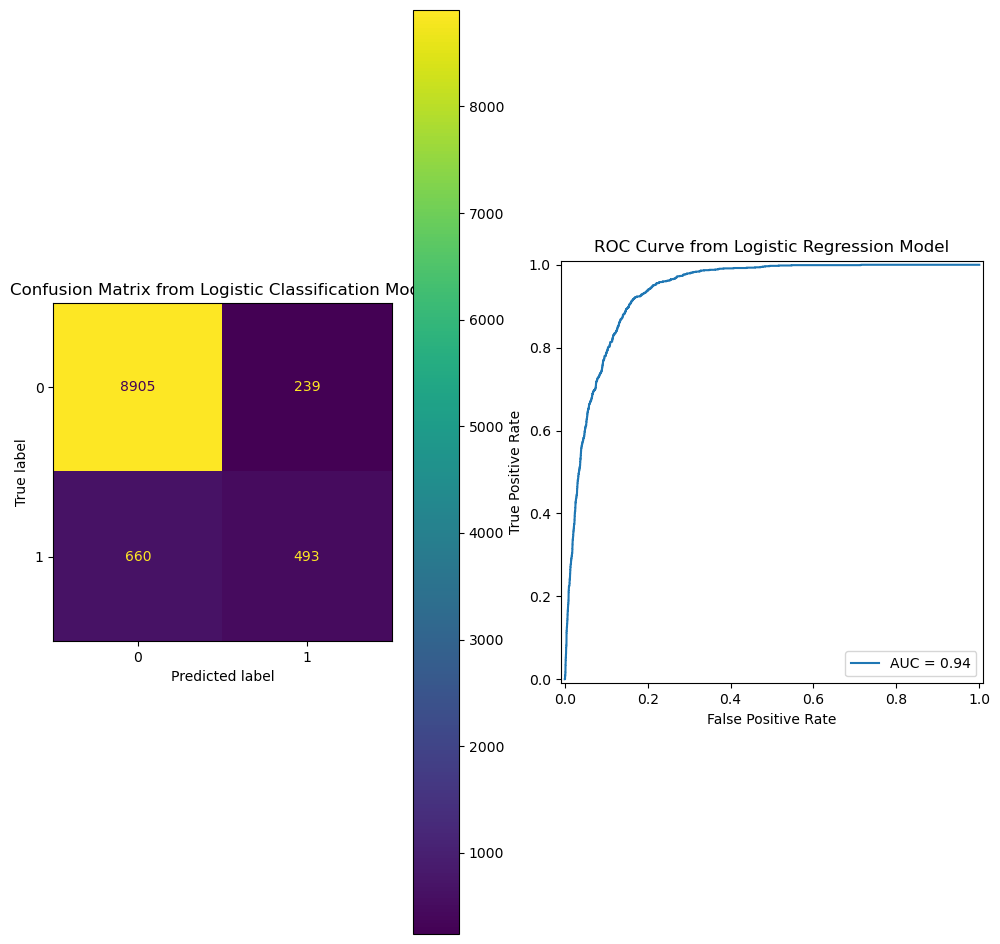

In [40]:
from sklearn.metrics import auc as skl_auc

lr_grid_preds = logreg_cv.predict(X_test)

fig, ax = plt.subplots(1, 2)

fig.set_size_inches(12, 12)
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, lr_grid_preds)
disp1 = ConfusionMatrixDisplay(conf_matrix)
disp1.plot(ax=ax[0])
ax[0].set_title('Confusion Matrix from Logistic Classification Model')

# ROC Curve
y_score = logreg_cv.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label=1)
lgr_roc_auc_value = skl_auc(fpr, tpr)

disp2 = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=lgr_roc_auc_value)
disp2.plot(ax=ax[1])
ax[1].set_title('ROC Curve from Logistic Regression Model')

fp = conf_matrix[0][1]
fn = conf_matrix[1][0]
auc = round(lgr_roc_auc_value, 2)

print(classification_report(y_test, lr_grid_preds))
print(confusion_matrix(y_test, lr_grid_preds))


### Decision Tree Explanation

              precision    recall  f1-score   support

           0       0.99      0.83      0.90      9144
           1       0.41      0.93      0.57      1153

    accuracy                           0.84     10297
   macro avg       0.70      0.88      0.73     10297
weighted avg       0.92      0.84      0.87     10297

[[7598 1546]
 [  86 1067]]


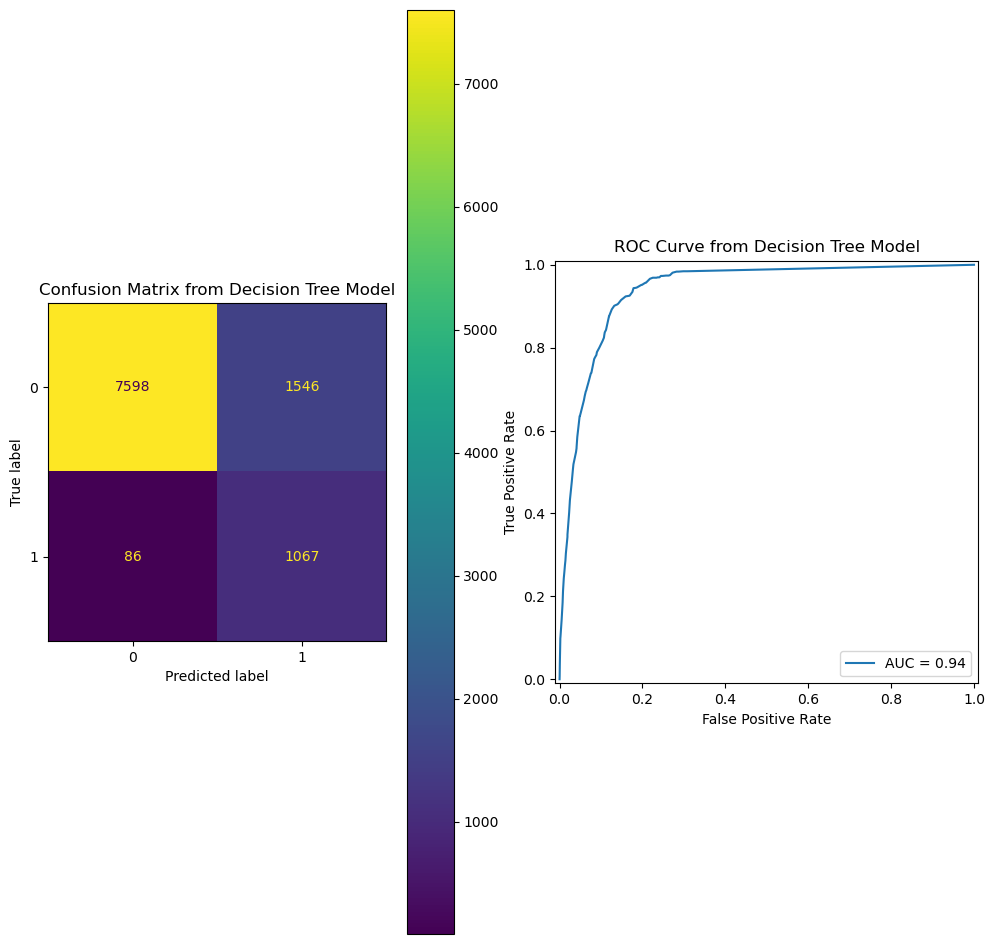

In [41]:

dt_preds = dt_grid.predict(X_test)

fig_dt, ax_dt = plt.subplots(1, 2)

fig_dt.set_size_inches(12, 12)
# Confusion Matrix
dt_conf_matrix = confusion_matrix(y_test, dt_preds)
disp_dt1 = ConfusionMatrixDisplay(dt_conf_matrix)
disp_dt1.plot(ax=ax_dt[0])
ax_dt[0].set_title('Confusion Matrix from Decision Tree Model')

# ROC Curve
dt_y_score = dt_grid.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, dt_y_score, pos_label=1)
dt_roc_auc_value = skl_auc(fpr, tpr)

disp_dt2 = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=dt_roc_auc_value)
disp_dt2.plot(ax=ax_dt[1])
ax_dt[1].set_title('ROC Curve from Decision Tree Model')

fp = conf_matrix[0][1]
fn = conf_matrix[1][0]
auc = round(dt_roc_auc_value, 2)

print(classification_report(y_test, dt_grid.predict(X_test)))
print(confusion_matrix(y_test, dt_grid.predict(X_test)))

<Axes: >

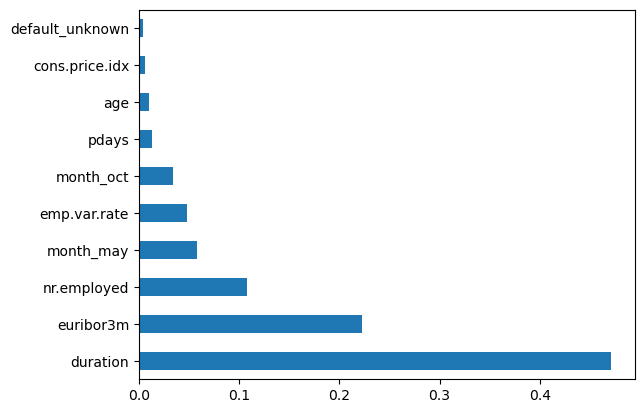

In [42]:
'''
Get the feature importance list
'''
df_fi = pd.DataFrame({'Feature': X_train.columns.tolist(), 'Relative Importance': dt_grid.best_estimator_.feature_importances_})
df_fi = df_fi.sort_values(by='Relative Importance', ascending=False).reset_index(drop=True)
    
df_fi

dt_model = dt_grid.best_estimator_
feat_importances = pd.Series(dt_model.feature_importances_, index=X_test.columns)
feat_importances.nlargest(10).plot(kind='barh')

### KNN Explanation

              precision    recall  f1-score   support

           0       0.93      0.98      0.95      9144
           1       0.66      0.37      0.48      1153

    accuracy                           0.91     10297
   macro avg       0.79      0.67      0.71     10297
weighted avg       0.90      0.91      0.90     10297

[[8922  222]
 [ 723  430]]


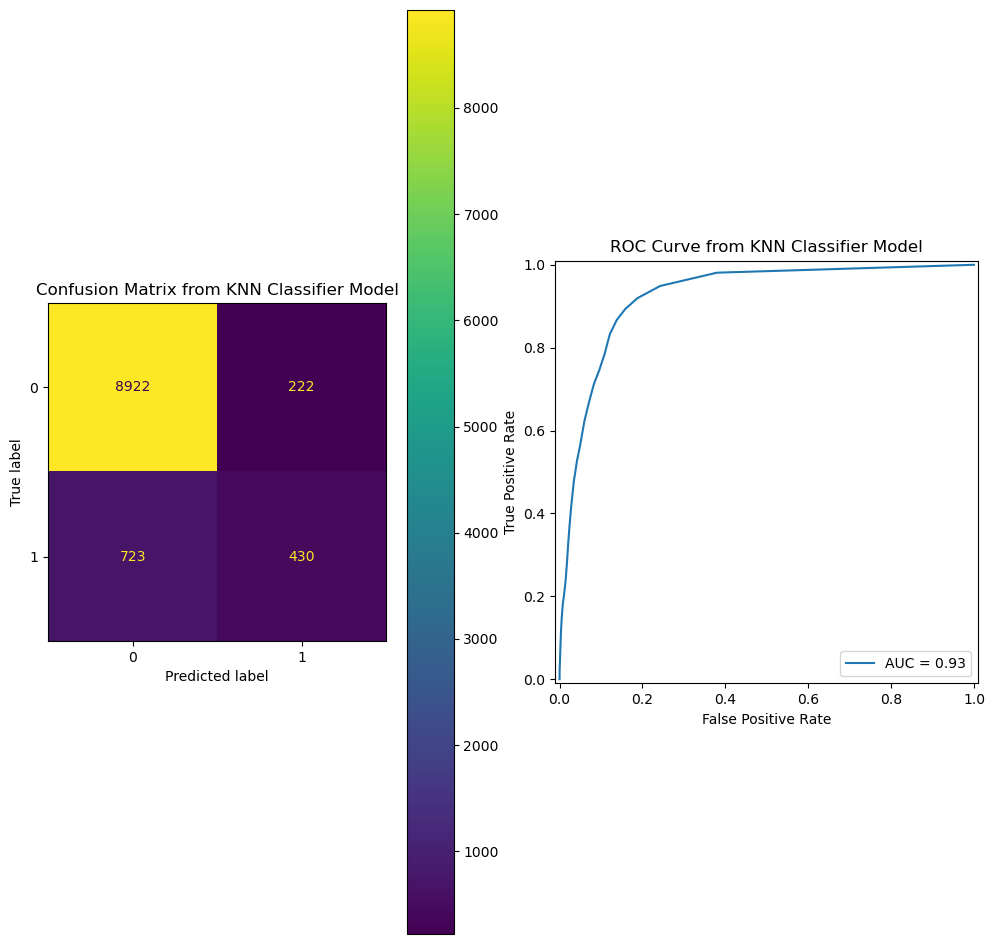

In [48]:

knn_preds = knn_grid.predict(X_test)

fig_knn, ax_knn = plt.subplots(1, 2)

fig_knn.set_size_inches(12, 12)
# Confusion Matrix
knn_conf_matrix = confusion_matrix(y_test, knn_preds)
disp_knn1 = ConfusionMatrixDisplay(knn_conf_matrix)
disp_knn1.plot(ax=ax_knn[0])
ax_knn[0].set_title('Confusion Matrix from KNN Classifier Model')

# ROC Curve
knn_y_score = knn_grid.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, knn_y_score, pos_label=1)
knn_roc_auc_value = skl_auc(fpr, tpr)

disp_knn2 = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=knn_roc_auc_value)
disp_knn2.plot(ax=ax_knn[1])
ax_knn[1].set_title('ROC Curve from KNN Classifier Model')

fp = conf_matrix[0][1]
fn = conf_matrix[1][0]
auc = round(knn_roc_auc_value, 2)

print(classification_report(y_test, knn_preds))
print(confusion_matrix(y_test, knn_preds))


### SVM Explanation

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      9144
           1       0.67      0.45      0.54      1153

    accuracy                           0.91     10297
   macro avg       0.80      0.71      0.74     10297
weighted avg       0.90      0.91      0.91     10297

[[8890  254]
 [ 638  515]]


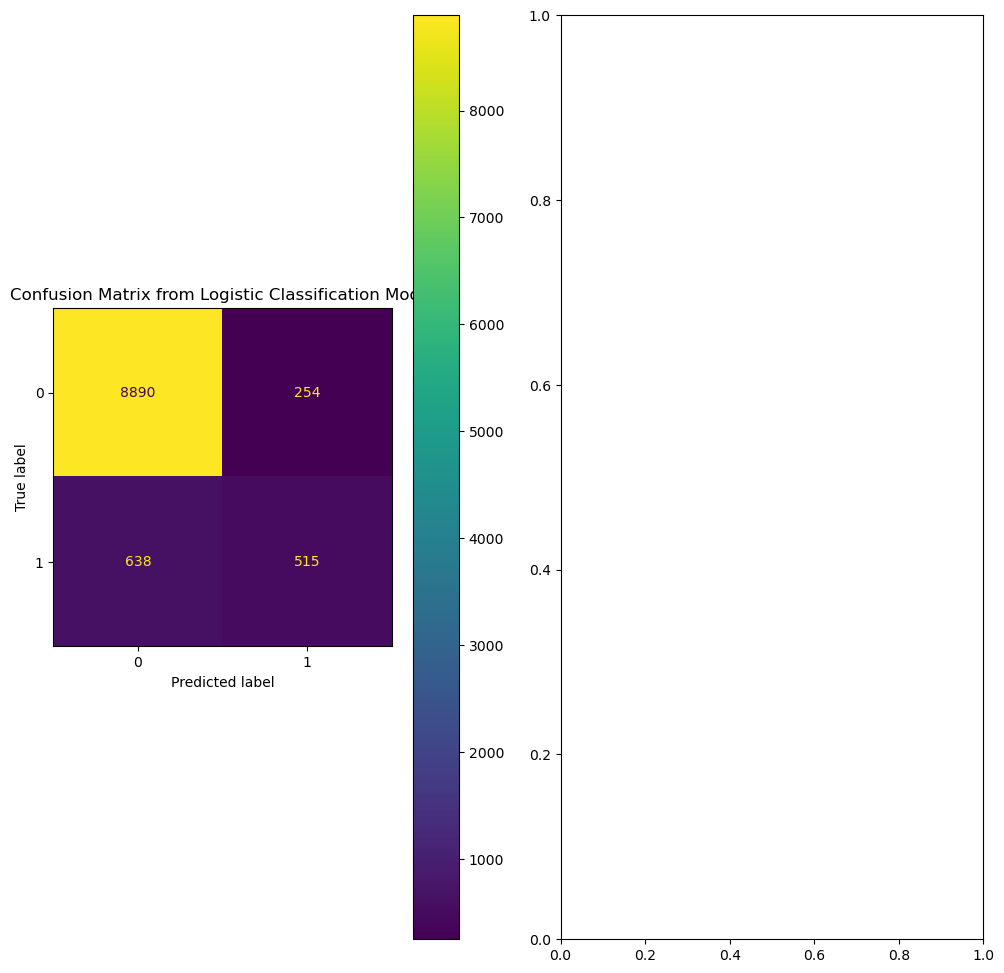

In [47]:
from sklearn.metrics import auc as skl_auc

svc_grid_preds = svc_grid.predict(X_test)

fig, ax = plt.subplots(1, 2)

fig.set_size_inches(12, 12)
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, svc_grid_preds)
disp1 = ConfusionMatrixDisplay(conf_matrix)
disp1.plot(ax=ax[0])
ax[0].set_title('Confusion Matrix from Logistic Classification Model')

# # ROC Curve
# y_score = svc_grid.predict_proba(X_test)[:, 1]
# fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label=1)
# svc_roc_auc_value = skl_auc(fpr, tpr)

# disp2 = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=svc_roc_auc_value)
# disp2.plot(ax=ax[1])
# ax[1].set_title('ROC Curve from Logistic Regression Model')

fp = conf_matrix[0][1]
fn = conf_matrix[1][0]
# auc = round(svc_roc_auc_value, 2)

print(classification_report(y_test, svc_grid_preds))
print(confusion_matrix(y_test, svc_grid_preds))


## Section 8: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.    Present your findings in a `DataFrame` similar to that below:


In [45]:
### 
knn_best_results =  knn_grid_best_params
dt_best_results = dt_best_params
lr_best_results = lr_grid_best_params
svc_best_results = svc_best_params

classifiers = pd.DataFrame({'Model': ['Knn', 'DecisionTree', 'LogisticRegressor', 'SVMClassifier'], 
              'Train Accuracy': [knn_best_results['train_acc'], dt_best_results['train_acc'], lr_best_results['train_acc'], svc_best_results['train_acc']],
              'Test Accuracy': [knn_best_results['test_acc'], dt_best_results['test_acc'], lr_best_results['test_acc'],svc_best_results['test_acc']],
              'Accuracy': [round(knn_best_results['accuracy'],3), round(dt_best_results['accuracy'],3), round(lr_best_results['accuracy'],3), round(svc_best_results['accuracy'],3)],
              'Precision': [round(knn_best_results['precision'],3), round(dt_best_results['precision'],3), round(lr_best_results['precision'],3), round(svc_best_results['precision'],3)],
              'Recall': [round(knn_best_results['recall'],3), round(dt_best_results['recall'],3), round(lr_best_results['recall'],3), round(svc_best_results['recall'],3)],
              'F1-Score': [round(knn_best_results['f1_score'],3), round(dt_best_results['f1_score'],3), round(lr_best_results['f1_score'],3), round(svc_best_results['f1_score'],3)],
              'Run Time(secs)': [round(knn_best_results['time'],3), round(dt_best_results['time'],3), round(lr_best_results['time'],3), round(svc_best_results['time'],3)]})

#classifiers['Model'] = 'baseline'
classifiers

,Model,Train Accuracy,Test Accuracy,Accuracy,Precision,Recall,F1-Score,Run Time(secs)
0,Knn,0.911,0.908,0.908,0.660,0.373,0.476,19.261
1,DecisionTree,0.850,0.840,0.842,0.408,0.925,0.567,36.630
2,LogisticRegressor,0.912,0.913,0.913,0.673,0.428,0.523,0.042
3,SVMClassifier,0.930,0.910,0.842,0.408,0.925,0.567,4861.240


# Conclusions

#### I ran several models to predict the target of whether a customer will subscribe to term deposit or not. Logistic Regressor was the fastest to train and SVM was the slowest.

#### - All models are performing well with accuracy > ~ 0.84.

#### - Decision Tree Classifer achieved highest F1-Score: 0.58 althought its accuracy is acceptably good with 85%. This model does not overfit. 
#### - Decision tree model has relatively higher recall (0.92) and low precision (0.4) and F1-score (0.58). Furthermore, this model does not high False negatives. False negatves are missed opportunities where model has missed to predict the customers who actually subscribed. The only model which reduces False negatives is Decision Tree Classifier and hence can be reported to be the best prediction model.



#### - Call duration is the top feature predicting high subscriptions to term deposit. Hence, model indicates that the longer the call duration, there is higher chance for customer to subscribe.
#### - Number of Employees - quarterly indicator (nr.employed) is the second top feature predicting subscriptions to term deposit indicating that the more the number of employees working and making calls, the more subscriptions we can get.
#### - Consumer Price Index (CPI) is third top feature which indicates that higher the CPI, the higher the subscription rate

## Recomendation

#### Keep motnitoring the modeling results as we add more data and monit for drifts in results
#### Add more data from more creative campaigns and iteratively refresh the model on new data to get latest and deeper perspetives of customers intending to subscribe

##### Questions